# Authorship Attribution for *Dream of the Red Chamber* (红楼梦)

- author: 'chaunice@163.com'
- date: '2024-01-26'

## Introduction

with reference to [Prose, Verse and Authorship in Dream of the Red Chamber: A Stylometric Analysis](https://www.researchgate.net/profile/Haoran-Zhu-8/publication/339140299_Prose_Verse_and_Authorship_in_Dream_of_the_Red_Chamber_A_Stylometric_Analysis/links/650fccd661f18040c21a3ff9/Prose-Verse-and-Authorship-in-Dream-of-the-Red-Chamber-A-Stylometric-Analysis.pdf)

## Preprocessing the data

- DRC text from https://github.com/buobao/HLM-txt

In [1]:
import re
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from statsmodels.stats.weightstats import ttest_ind

In [3]:
def separate_verses_and_prose(data):
    # Compile regex patterns
    verse_pattern = re.compile(r'<blockquote([\s\S]*?)</blockquote>')
    prose_pattern = re.compile(r'<p>([\s\S]*?)</p>')

    # Find all verses
    verses = re.findall(verse_pattern, data)
    verses = [verse.strip() for verse in verses]  # Remove leading/trailing whitespace

    # Remove verses from data
    data = re.sub(verse_pattern, '', data)

    # Find all prose
    prose = re.findall(prose_pattern, data)
    prose = [p.strip() for p in prose]  # Remove leading/trailing whitespace

    return verses, prose

def glob_markdown_files(directory):
    return list(Path(directory).glob('*.md'))

# batch process all files and store results in a csv while keeping track of the file name
def batch_process_files(directory):
    markdown_files = glob_markdown_files(directory)
    results = []
    for file in markdown_files:
        with open(file, 'r', encoding='utf-8') as f:
            data = f.read()
        verses, prose = separate_verses_and_prose(data)
        results.append({'File': file.name, 'Verses': verses, 'Prose': prose})
    df = pd.DataFrame(results)
    df.to_csv('DRC_text.csv', index=False)

In [4]:
batch_process_files('full/')

In [5]:
df = pd.read_csv('DRC_text.csv')

In [6]:
# clean up the text by removing punctuations and only retaining chinese characters
def clean_text(text):
    text = re.sub(r'[^\u4e00-\u9fff]', '', text)
    return text

df['Verses'] = df['Verses'].apply(lambda x: [clean_text(verse) for verse in x])
df['Prose'] = df['Prose'].apply(lambda x: [clean_text(p) for p in x])

# remove empty verses and prose
df['Verses'] = df['Verses'].apply(lambda x: [verse for verse in x if verse])
df['Prose'] = df['Prose'].apply(lambda x: [p for p in x if p])

In [7]:
df.to_csv('DRC_text_clean.csv', index=False, sep='\t', encoding='utf-8')

## Analysis

### Transform the data

In [2]:
df = pd.read_csv('DRC_text_clean.csv', sep='\t', encoding='utf-8')

In [3]:
# count the number of characters in each verse and prose group by 10 files so that we get 12 groups
df['VerseLength'] = df['Verses'].apply(lambda x: [len(verse) for verse in x])
df['ProseLength'] = df['Prose'].apply(lambda x: [len(p) for p in x])
df['VerseLength'] = df['VerseLength'].apply(lambda x: [len(x)])
df['ProseLength'] = df['ProseLength'].apply(lambda x: [len(x)])

# 10 files as a group
df['Groups'] = (df.index // 10) + 1

# sum the length of verses and prose in each group
df = df.groupby('Groups').sum()
# calculate the sum of verses and prose in each group
df['VerseCount'] = df['VerseLength'].apply(lambda x: sum(x))
df['ProseCount'] = df['ProseLength'].apply(lambda x: sum(x))

df['Proportion of Verse'] = df['VerseCount'] / (df['VerseCount'] + df['ProseCount'])

df['Groups'] = df.index

# 用正则表达式删除所有标点符号和空格
df['Verses'] = df['Verses'].apply(lambda x: re.sub(r'[^\u4e00-\u9fff]', '', x))
df['Prose'] = df['Prose'].apply(lambda x: re.sub(r'[^\u4e00-\u9fff]', '', x))

# 创建一个新的列来区分前4组，中间4组和后4组
df['Group_sep'] = ['Group 1-4']*4 + ['Group 5-8']*4 + ['Group 9-12']*4

In [4]:
df.columns

Index(['File', 'Verses', 'Prose', 'VerseLength', 'ProseLength', 'VerseCount',
       'ProseCount', 'Proportion of Verse', 'Groups', 'Group_sep'],
      dtype='object')

### Plot the data

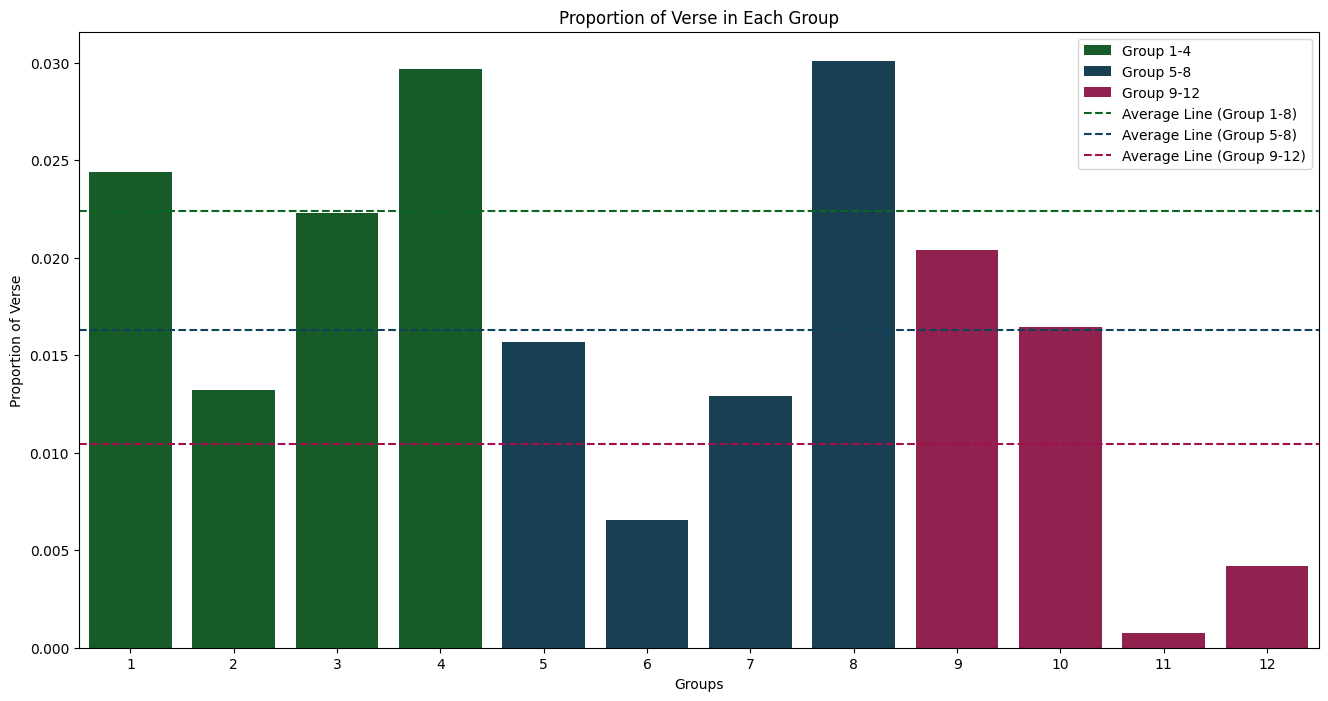

In [5]:
# plot the results concentrating 'Proportion of Verse'
# 创建一个字典，将组名映射到 Chicago 配色的颜色代码
chicago_palette = {'Group 1-4': '#0b6623', 'Group 5-8': '#0F425CFF', 'Group 9-12': '#a40e4c'}

# 创建柱状图
plt.figure(figsize=(16, 8))
sns.barplot(x=df.index, y=df['Proportion of Verse'], hue=df['Group_sep'], dodge=False, palette=chicago_palette)

# 计算前8组和后4组的平均值
average_line_1_4 = df.loc[1:4, 'Proportion of Verse'].mean()
average_line_5_8 = df.loc[5:8, 'Proportion of Verse'].mean()
average_line_9_12 = df.loc[9:12, 'Proportion of Verse'].mean()

# 绘制平均线
plt.axhline(average_line_1_4, color='#0b6623', linestyle='--', label='Average Line (Group 1-8)')
plt.axhline(average_line_5_8, color='#0F425CFF', linestyle='--', label='Average Line (Group 5-8)')
plt.axhline(average_line_9_12, color='#a40e4c', linestyle='--', label='Average Line (Group 9-12)')

plt.xlabel('Groups')
plt.ylabel('Proportion of Verse')
plt.title('Proportion of Verse in Each Group')
plt.legend()

plt.show()

### T-test

In [15]:
# perform T-test to see if there is a significant difference between group 1-4, group 5-8 and group 9-12
ttest_df = df[['Proportion of Verse', 'Group_sep']]

# 将数据分成三组
group_1_4 = ttest_df[ttest_df['Group_sep'] == 'Group 1-4']['Proportion of Verse']
group_5_8 = ttest_df[ttest_df['Group_sep'] == 'Group 5-8']['Proportion of Verse']
group_9_12 = ttest_df[ttest_df['Group_sep'] == 'Group 9-12']['Proportion of Verse']

# 进行 T 检验
t1, p1, df1 = ttest_ind(group_1_4, group_5_8)
t2, p2, df2 = ttest_ind(group_1_4, group_9_12)
t3, p3, df3 = ttest_ind(group_5_8, group_9_12)

print('T-test results for Group 1-4 and Group 5-8: t = %.3f, p = %.3f' % (t1, p1))
print('T-test results for Group 1-4 and Group 9-12: t = %.3f, p = %.3f' % (t2, p2))
print('T-test results for Group 5-8 and Group 9-12: t = %.3f, p = %.3f' % (t3, p3))

T-test results for Group 1-4 and Group 5-8: t = 1.007, p = 0.353
T-test results for Group 1-4 and Group 9-12: t = 2.045, p = 0.087
T-test results for Group 5-8 and Group 9-12: t = 0.854, p = 0.426


### PCA: Principal Component Analysis

In [6]:
# 对 Prose 进行取样，去尾取样， 分成 segments，每个 segment 有 segment_size 个字符
def sample_prose(prose, segment_size):
    # 去尾取样
    remainder = len(prose) % segment_size
    prose = prose[:-remainder]

    # 分成连续的 segments，每个 segment 有 segment_size 个字符
    segments = [prose[i:i+segment_size] for i in range(0, len(prose), segment_size)]
    return segments

In [7]:
# 定义一个函数，找到合并所有的 Segmented Prose 后最频繁出现的 n 个字符
def get_top_n_chars(df, n):
    # 合并所有的 Segmented Prose
    prose = ''.join(df['Segmented Prose'].tolist())

    # 使用 Counter 来统计每个字符出现的次数
    char_counts = Counter(prose)

    # 将字符按出现次数从高到低排序
    char_counts = char_counts.most_common(n)

    # 返回前 n 个字符
    return [char[0] for char in char_counts]

In [268]:
def perform_pca(df, segment_size, n, original=False):
    df = df.copy()
    
    # df 保留 Prose, 然后按 Group_sep 合并
    df = df[['Prose', 'Group_sep']]
    df = df.groupby('Group_sep').sum()
    
    # 对 prose 进行取样
    df['Segmented Prose'] = df['Prose'].apply(lambda x: sample_prose(x, segment_size))

    if original:
        # 合并 Group_1-4 和 Group_5-8
        df.loc['Group 1-8'] = df.loc['Group 1-4'] + df.loc['Group 5-8']
        # 删除 Group_1-4 和 Group_5-8
        df.drop(['Group 1-4', 'Group 5-8'], inplace=True)
        
        # 展开列表
        seg_df = df.explode('Segmented Prose').reset_index()
        seg_df = seg_df.drop('Prose', axis=1)

        # 找到最频繁出现的 n 个字符
        mfc_list = get_top_n_chars(seg_df, n)

        char_counts = {char: seg_df['Segmented Prose'].apply(lambda x: x.count(char)) for char in mfc_list}

        # 将结果添加到 seg_df 中
        seg_df = pd.concat([seg_df, pd.DataFrame(char_counts)], axis=1)
        
        seg_df.drop('Segmented Prose', axis=1, inplace=True)
        
        sample_num = seg_df.query('Group_sep == "Group 9-12"').shape[0]
        
        # 对 Group 1-8 进行下采样，保证 Group 1-8 和 Group 9-12 的数量一致，并且随机种子为 42
        seg_df = seg_df.groupby('Group_sep').apply(lambda x: x.sample(n=sample_num, random_state=42)).reset_index(drop=True)

    else:    
        # 展开列表
        seg_df = df.explode('Segmented Prose').reset_index()
        seg_df = seg_df.drop('Prose', axis=1)

        # 找到最频繁出现的 n 个字符
        mfc_list = get_top_n_chars(seg_df, n)

        char_counts = {char: seg_df['Segmented Prose'].apply(lambda x: x.count(char)) for char in mfc_list}

        # 将结果添加到 seg_df 中
        seg_df = pd.concat([seg_df, pd.DataFrame(char_counts)], axis=1)
        
        seg_df.drop('Segmented Prose', axis=1, inplace=True)

    # 进行主成分分析
    pca = PCA(n_components=2)
    pca.fit(seg_df.drop('Group_sep', axis=1))
    pca_df = pd.DataFrame(pca.transform(seg_df.drop('Group_sep', axis=1)), columns=['PC1', 'PC2'])
    pca_df['Group_sep'] = seg_df['Group_sep']
    
    # return Segmented_Prose_list_1_8, Segmented_Prose_list_9_12, df2, seg_df
    return pca_df

In [29]:
def get_pca_results(df, original=False):
    # 初始化一个空字典来保存结果
    pca_results = {}

    # 遍历样本大小和 n 的组合
    for segment_size in [1000, 2000, 3000, 4000, 5000]:
        for n in [50, 75, 100, 125, 150]:
            # 执行 PCA
            pca_df = perform_pca(df, segment_size, n, original=original)
            
            # 保存结果
            pca_results[(segment_size, n)] = pca_df
            
    return pca_results

In [23]:
def plot_pca_results(pca_results, original=False):
    # 创建一个 5x5 的图像网格
    fig, axs = plt.subplots(5, 5, figsize=(25, 25))

    # 遍历所有的结果
    for i, ((sample_size, max_features), temp_df_pca) in enumerate(pca_results.items()):
        # 计算当前子图的位置
        row = i // 5
        col = i % 5
        
        # 绘制散点图
        ax = axs[row, col]

        chicago_palette = {'Group 1-4': '#C16622FF', 'Group 5-8': '#155F83FF', 'Group 9-12': '#8A9045FF'}
        # chicago_palette = {'Group 1-4': '#C16622FF', 'Group 5-8': '#155F83FF', 'Group 9-12': '#FFFFFF00'}
        # chicago_palette = {'Group 1-4': '#C16622FF', 'Group 5-8': '#FFFFFF00', 'Group 9-12': '#155F83FF'}
        # chicago_palette = {'Group 1-4': '#FFFFFF00', 'Group 5-8': '#C16622FF', 'Group 9-12': '#155F83FF'}
        
        if original:
            chicago_palette = {'Group 1-8': '#C16622FF', 'Group 9-12': '#155F83FF'}
        
        sns.scatterplot(x='PC1', y='PC2', hue='Group_sep', data=temp_df_pca, palette=chicago_palette, ax=ax)
        
        # 设置标题
        ax.set_title(f'Sample Size: {sample_size}, Max Features: {max_features}')

    # 调整子图之间的间距    
    plt.tight_layout()


In [33]:
def auto_conducting_PCA(df, original=False):    
    plot_pca_results(get_pca_results(df, original=original), original=original)   

C:\Users\Chaun\AppData\Local\Temp\ipykernel_23704\4217420322.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_df = seg_df.groupby('Group_sep', group_keys=False).apply(lambda x: x.sample(n=sample_num, random_state=42)).reset_index(drop=True)
C:\Users\Chaun\AppData\Local\Temp\ipykernel_23704\4217420322.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_df = seg_df.groupby('Group_sep', group_keys

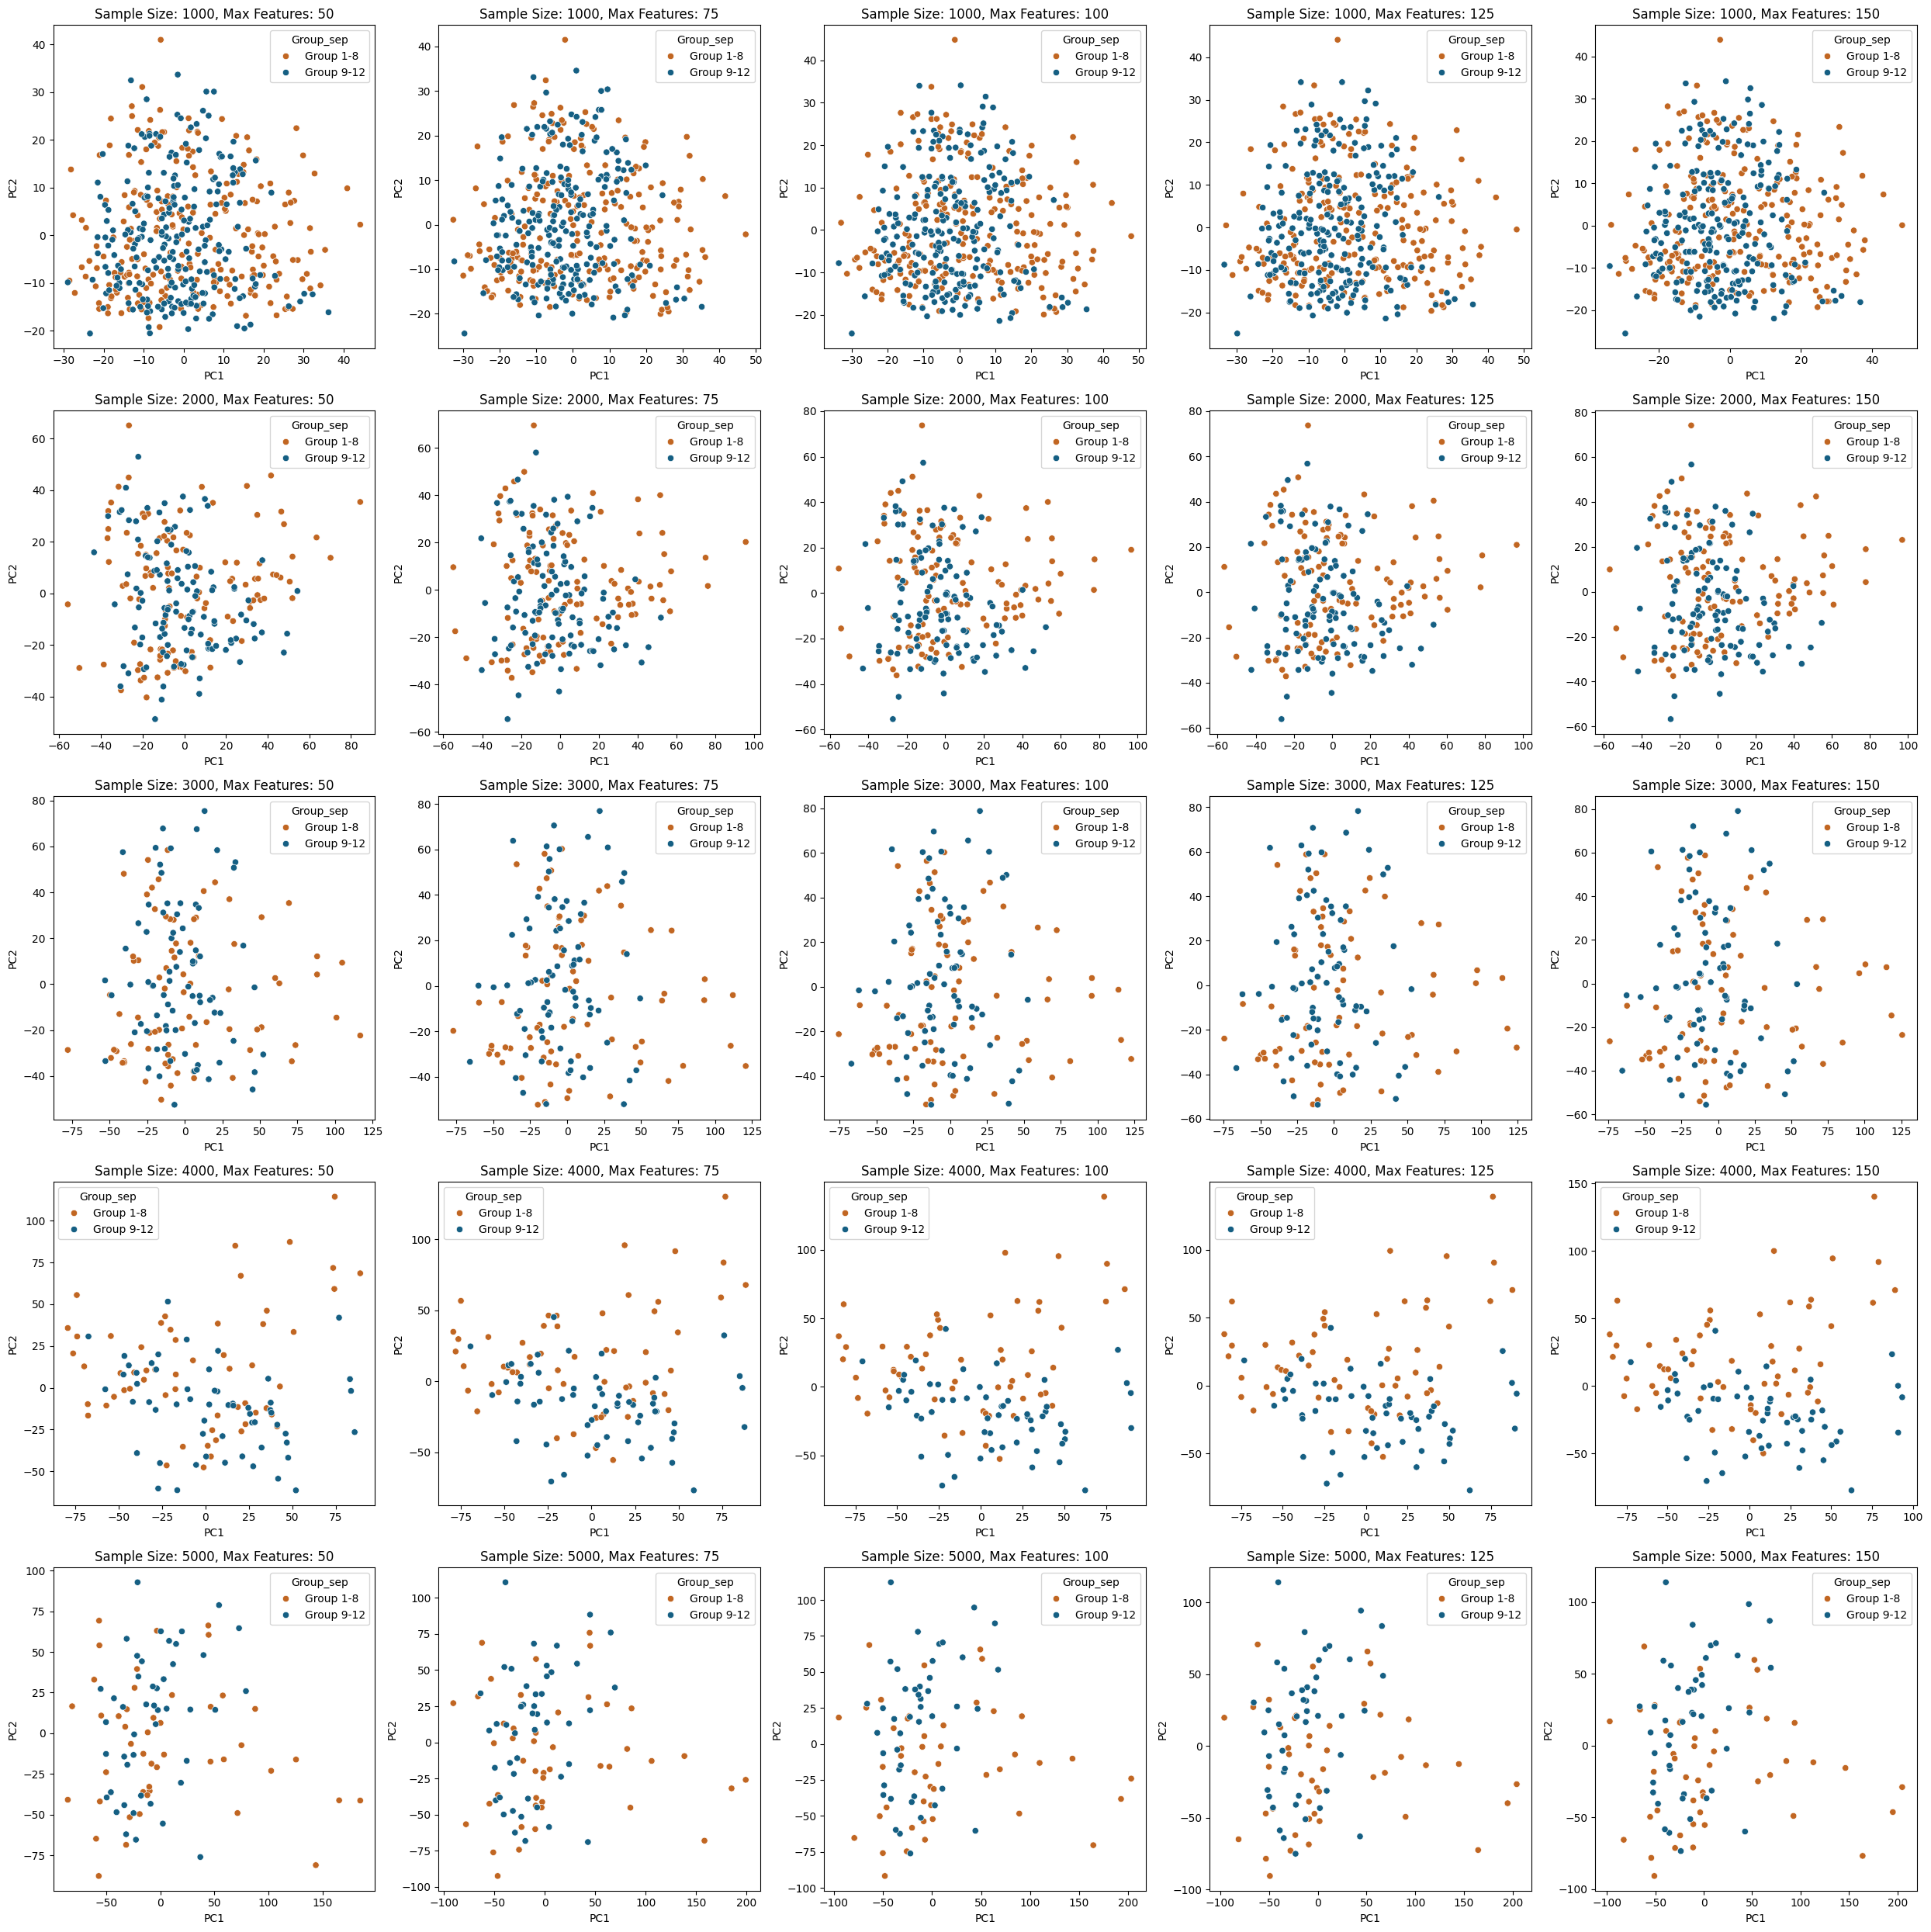

In [265]:
auto_conducting_PCA(df, original=True)

### T-SNE: t-distributed Stochastic Neighbor Embedding

In [270]:
def perform_tsne(df, segment_size, n, original=False):
    # df 保留 Prose, 然后按 Group_sep 合并
    df = df[['Prose', 'Group_sep']]
    df = df.groupby('Group_sep').sum()
    
    # 对 prose 进行取样
    df['Segmented Prose'] = df['Prose'].apply(lambda x: sample_prose(x, segment_size))

    if original:
        # 合并 Group_1-4 和 Group_5-8
        df.loc['Group 1-8'] = df.loc['Group 1-4'] + df.loc['Group 5-8']
        # 删除 Group_1-4 和 Group_5-8
        df.drop(['Group 1-4', 'Group 5-8'], inplace=True)
        
        # 展开列表
        seg_df = df.explode('Segmented Prose').reset_index()
        seg_df = seg_df.drop('Prose', axis=1)

        # 找到最频繁出现的 n 个字符
        mfc_list = get_top_n_chars(seg_df, n)

        char_counts = {char: seg_df['Segmented Prose'].apply(lambda x: x.count(char)) for char in mfc_list}

        # 将结果添加到 seg_df 中
        seg_df = pd.concat([seg_df, pd.DataFrame(char_counts)], axis=1)
        
        seg_df.drop('Segmented Prose', axis=1, inplace=True)
        
        sample_num = seg_df.query('Group_sep == "Group 9-12"').shape[0]
        
        # 对 Group 1-8 进行下采样，保证 Group 1-8 和 Group 9-12 的数量一致，并且随机种子为 42
        seg_df = seg_df.groupby('Group_sep').apply(lambda x: x.sample(n=sample_num, random_state=42)).reset_index(drop=True)

    else:
        # 展开列表
        seg_df = df.explode('Segmented Prose').reset_index()
        seg_df = seg_df.drop('Prose', axis=1)

        # 找到最频繁出现的 n 个字符
        mfc_list = get_top_n_chars(seg_df, n)

        char_counts = {char: seg_df['Segmented Prose'].apply(lambda x: x.count(char)) for char in mfc_list}

        # 将结果添加到 seg_df 中
        seg_df = pd.concat([seg_df, pd.DataFrame(char_counts)], axis=1)
        
        seg_df.drop('Segmented Prose', axis=1, inplace=True)

    # 进行 t-SNE
    tsne = TSNE(n_components=2)
    tsne.fit(seg_df.drop('Group_sep', axis=1))
    tsne_df = pd.DataFrame(tsne.embedding_, columns=['tsne1', 'tsne2'])
    tsne_df['Group_sep'] = seg_df['Group_sep']
    
    return tsne_df

In [41]:
def get_tsne_results(df, original=False):
    # 初始化一个空字典来保存结果
    tsne_results = {}

    # 遍历样本大小和 n 的组合
    for segment_size in [1000, 2000, 3000, 4000, 5000]:
        for n in [50, 75, 100, 125, 150]:
            # 执行 t-SNE
            tsne_df = perform_tsne(df, segment_size, n, original=original)
            
            # 保存结果
            tsne_results[(segment_size, n)] = tsne_df
            
    return tsne_results

In [38]:
def plot_tsne_results(tsne_results, original=False):
    # 创建一个 5x5 的图像网格
    fig, axs = plt.subplots(5, 5, figsize=(25, 25))

    # 遍历所有的结果
    for i, ((sample_size, max_features), temp_df_tsne) in enumerate(tsne_results.items()):
        # 计算当前子图的位置
        row = i // 5
        col = i % 5
        
        # 绘制散点图
        ax = axs[row, col]

        chicago_palette = {'Group 1-4': '#C16622FF', 'Group 5-8': '#155F83FF', 'Group 9-12': '#8A9045FF'}
        # chicago_palette = {'Group 1-4': '#C16622FF', 'Group 5-8': '#155F83FF', 'Group 9-12': '#FFFFFF00'}
        # chicago_palette = {'Group 1-4': '#C16622FF', 'Group 5-8': '#FFFFFF00', 'Group 9-12': '#155F83FF'}
        # chicago_palette = {'Group 1-4': '#FFFFFF00', 'Group 5-8': '#C16622FF', 'Group 9-12': '#155F83FF'}
        
        if original:
            chicago_palette = {'Group 1-8': '#C16622FF', 'Group 9-12': '#155F83FF'}
        
        sns.scatterplot(x='tsne1', y='tsne2', hue='Group_sep', data=temp_df_tsne, palette=chicago_palette, ax=ax)
        
        # 设置标题
        ax.set_title(f'Sample Size: {sample_size}, Max Features: {max_features}')
        
    # 调整子图之间的间距
    plt.tight_layout()

In [39]:
def auto_conducting_tsne(df, original=False):    
    plot_tsne_results(get_tsne_results(df, original=original), original=original)

C:\Users\Chaun\AppData\Local\Temp\ipykernel_23704\2247049981.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_df = seg_df.groupby('Group_sep').apply(lambda x: x.sample(n=sample_num, random_state=42)).reset_index(drop=True)
C:\Users\Chaun\AppData\Local\Temp\ipykernel_23704\2247049981.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seg_df = seg_df.groupby('Group_sep').apply(lambda x: x.sample(n=s

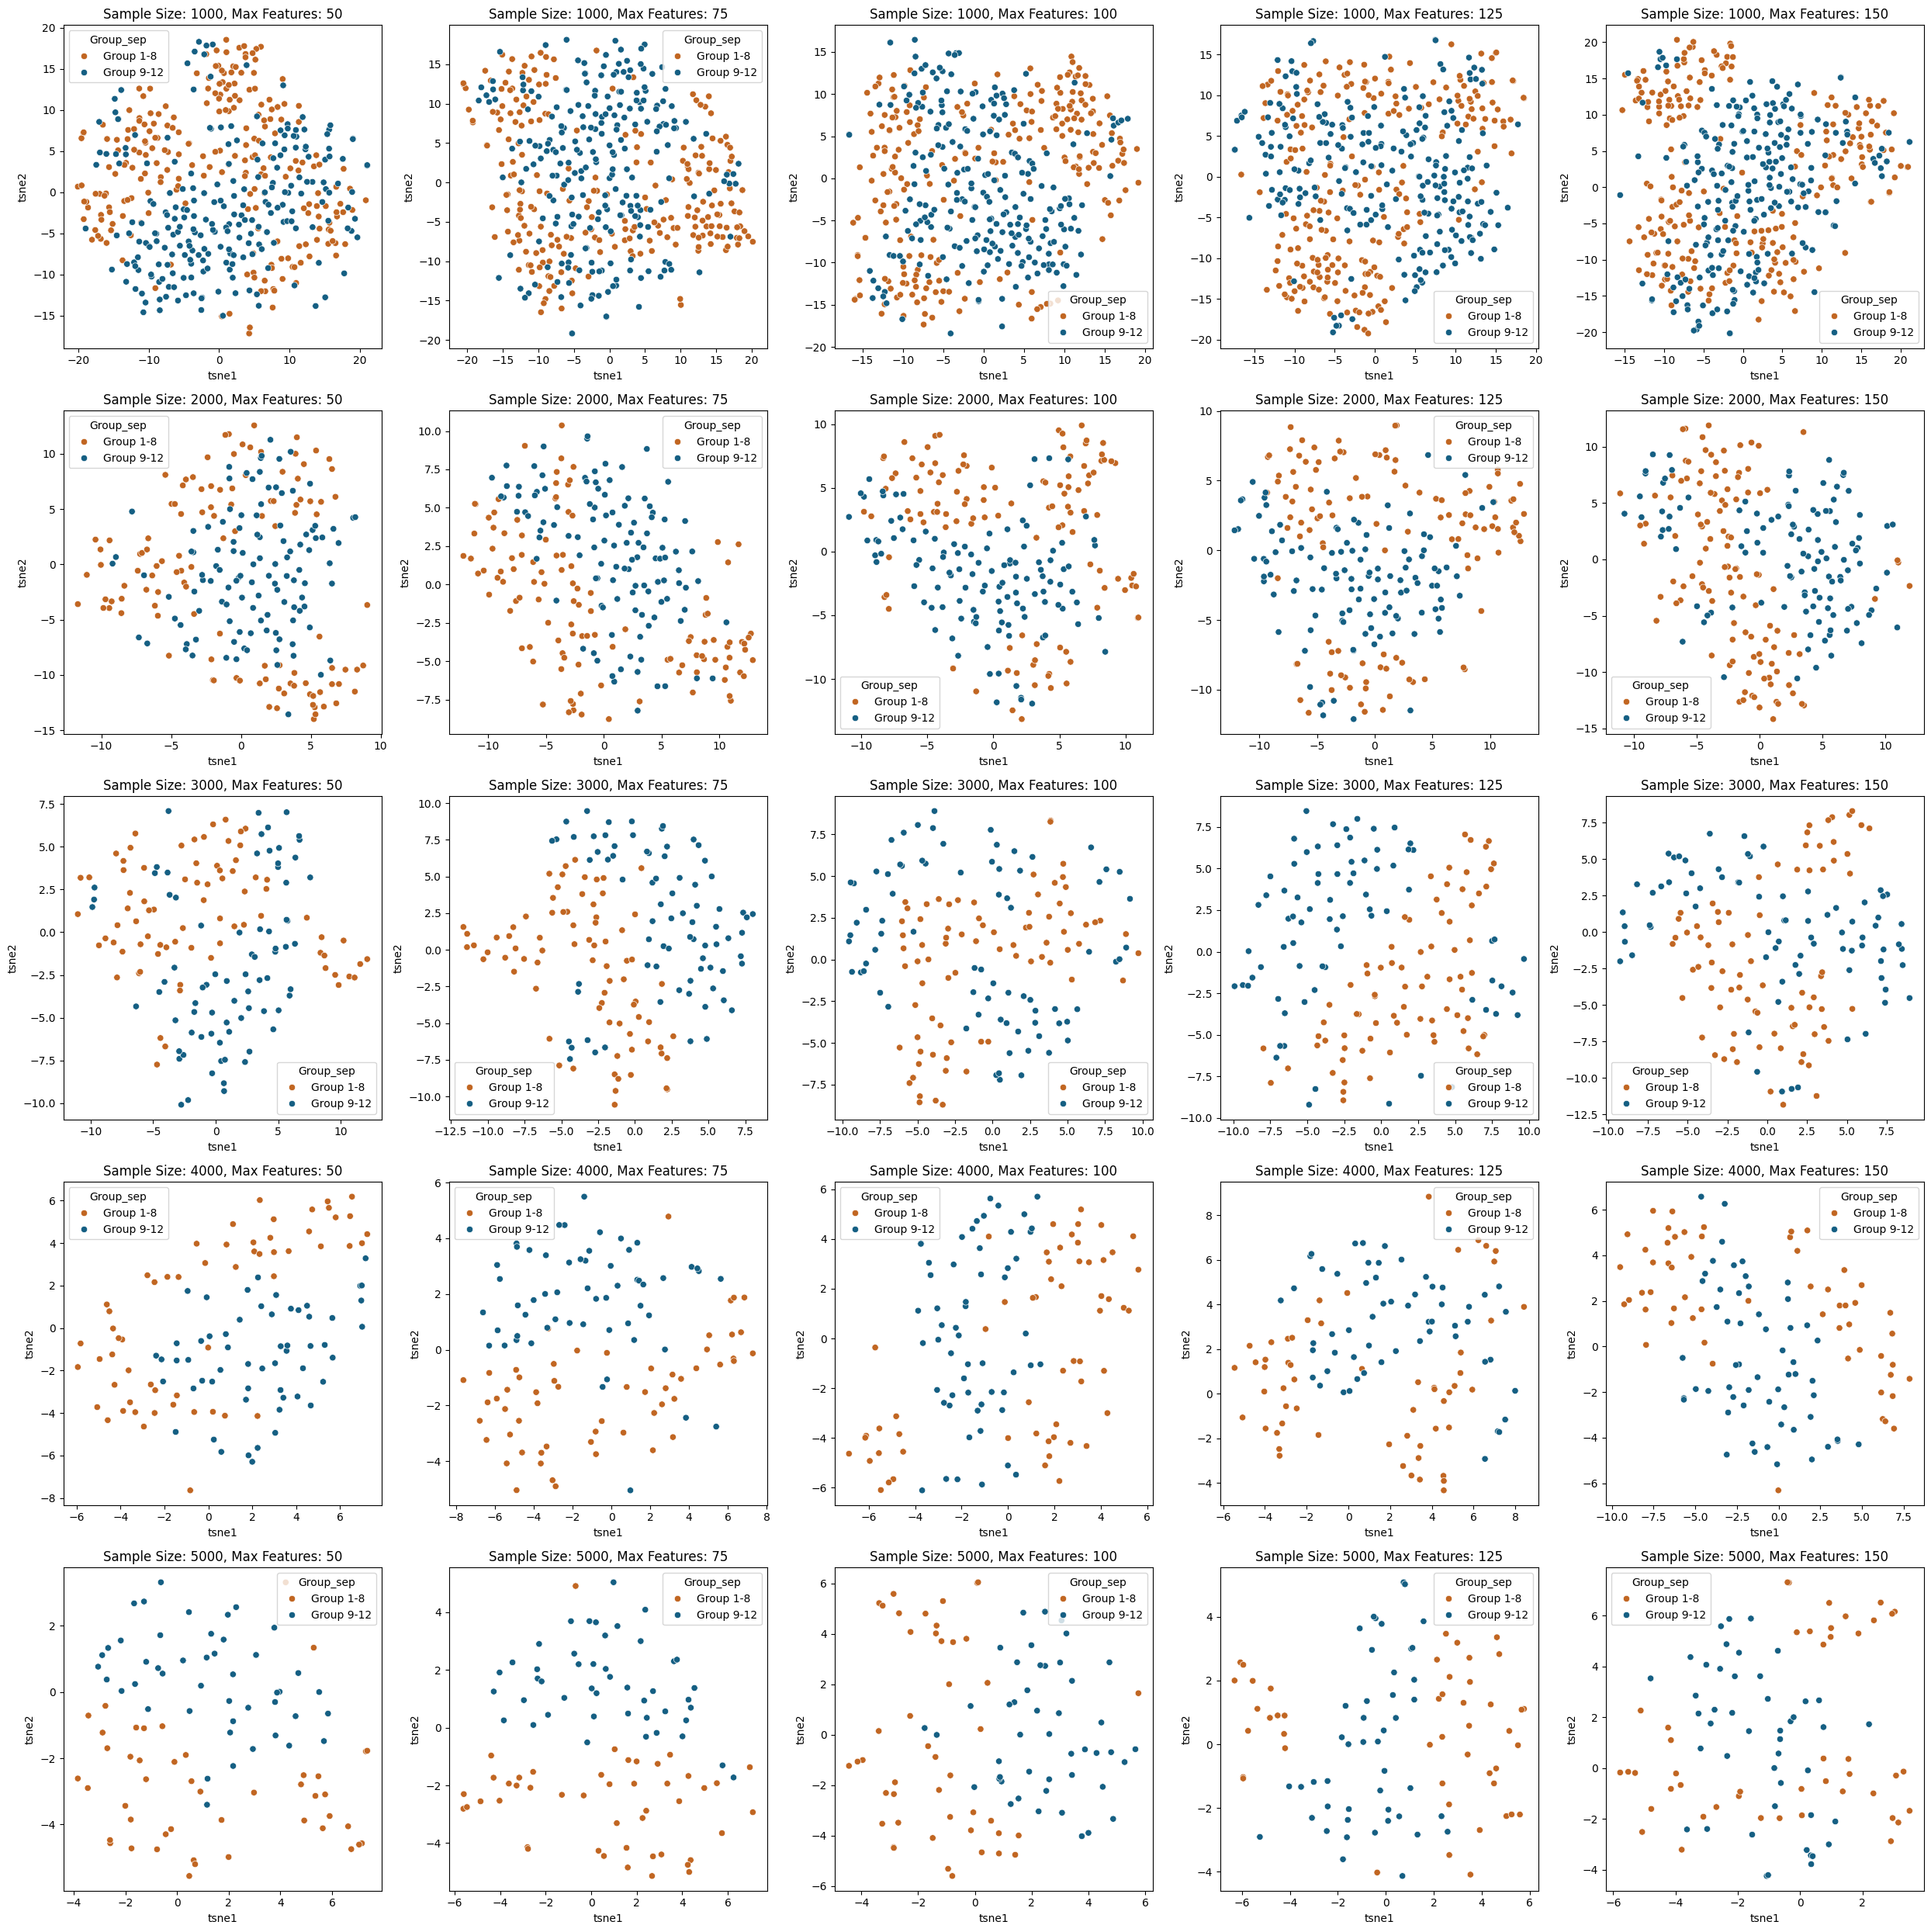

In [272]:
auto_conducting_tsne(df, original=True)

### PCA: Principal Component Analysis [Chaunice's version]

In [154]:
# 定义一个函数，从一个字符串中随机抽取n个字符
def sample_chars(s, n):
    return ''.join(random.sample(s, min(n, len(s))))

In [155]:
def cmex_pca(dataframe, sample_size, max_features, n_components):
    # 创建 df 的副本
    df = dataframe.copy()
    
    # 重复100次，每次都从每个组中随机抽取 sample_size 个字符，然后计算字符计数矩阵
    char_counts_list = []
    for i in range(100):
        df_sample = df.groupby('Group_sep').apply(lambda x: sample_chars(''.join(x['Prose']), sample_size), include_groups=False).reset_index()
        df_sample[0] = df_sample[0].apply(lambda x: ''.join(list(x)))
        vectorizer = CountVectorizer(analyzer='char', max_features=max_features)
        char_counts = vectorizer.fit_transform(df_sample[0])
        char_counts_df = pd.DataFrame(char_counts.toarray(), columns=vectorizer.get_feature_names_out())
        char_counts_list.append(char_counts_df)
        
    # 将所有字符计数矩阵连接起来，保留分组信息
    char_counts_df = pd.concat(char_counts_list, keys=range(100))

    # 将空值替换为 0
    char_counts_df = char_counts_df.fillna(0)

    # 转换 char_counts_df，将分组信息转换为列
    char_counts_df = char_counts_df.reset_index().rename(columns={'level_0': 'Sample', 'level_1': 'Group_sep'})

    # 分组进行PCA，保留分组信息方便后续绘图
    pca = PCA(n_components=n_components)
    char_counts_df_pca = pca.fit_transform(char_counts_df.drop(['Sample', 'Group_sep'], axis=1))
    char_counts_df_pca = pd.DataFrame(char_counts_df_pca, columns=['PC1', 'PC2'])
    char_counts_df_pca['Sample'] = char_counts_df['Sample']
    char_counts_df_pca['Group_sep'] = char_counts_df['Group_sep']
    return char_counts_df_pca

In [156]:
# 初始化一个空字典来保存结果
cmex_pca_results = {}

# 遍历样本大小
for sample_size in [1000, 2000, 3000, 4000, 5000]:
    # 遍历特征数量
    for max_features in [50, 75, 100, 125, 150]:
        # 调用函数并保存结果
        key = (sample_size, max_features)
        cmex_pca_results[key] = cmex_pca(df, sample_size, max_features, 2)

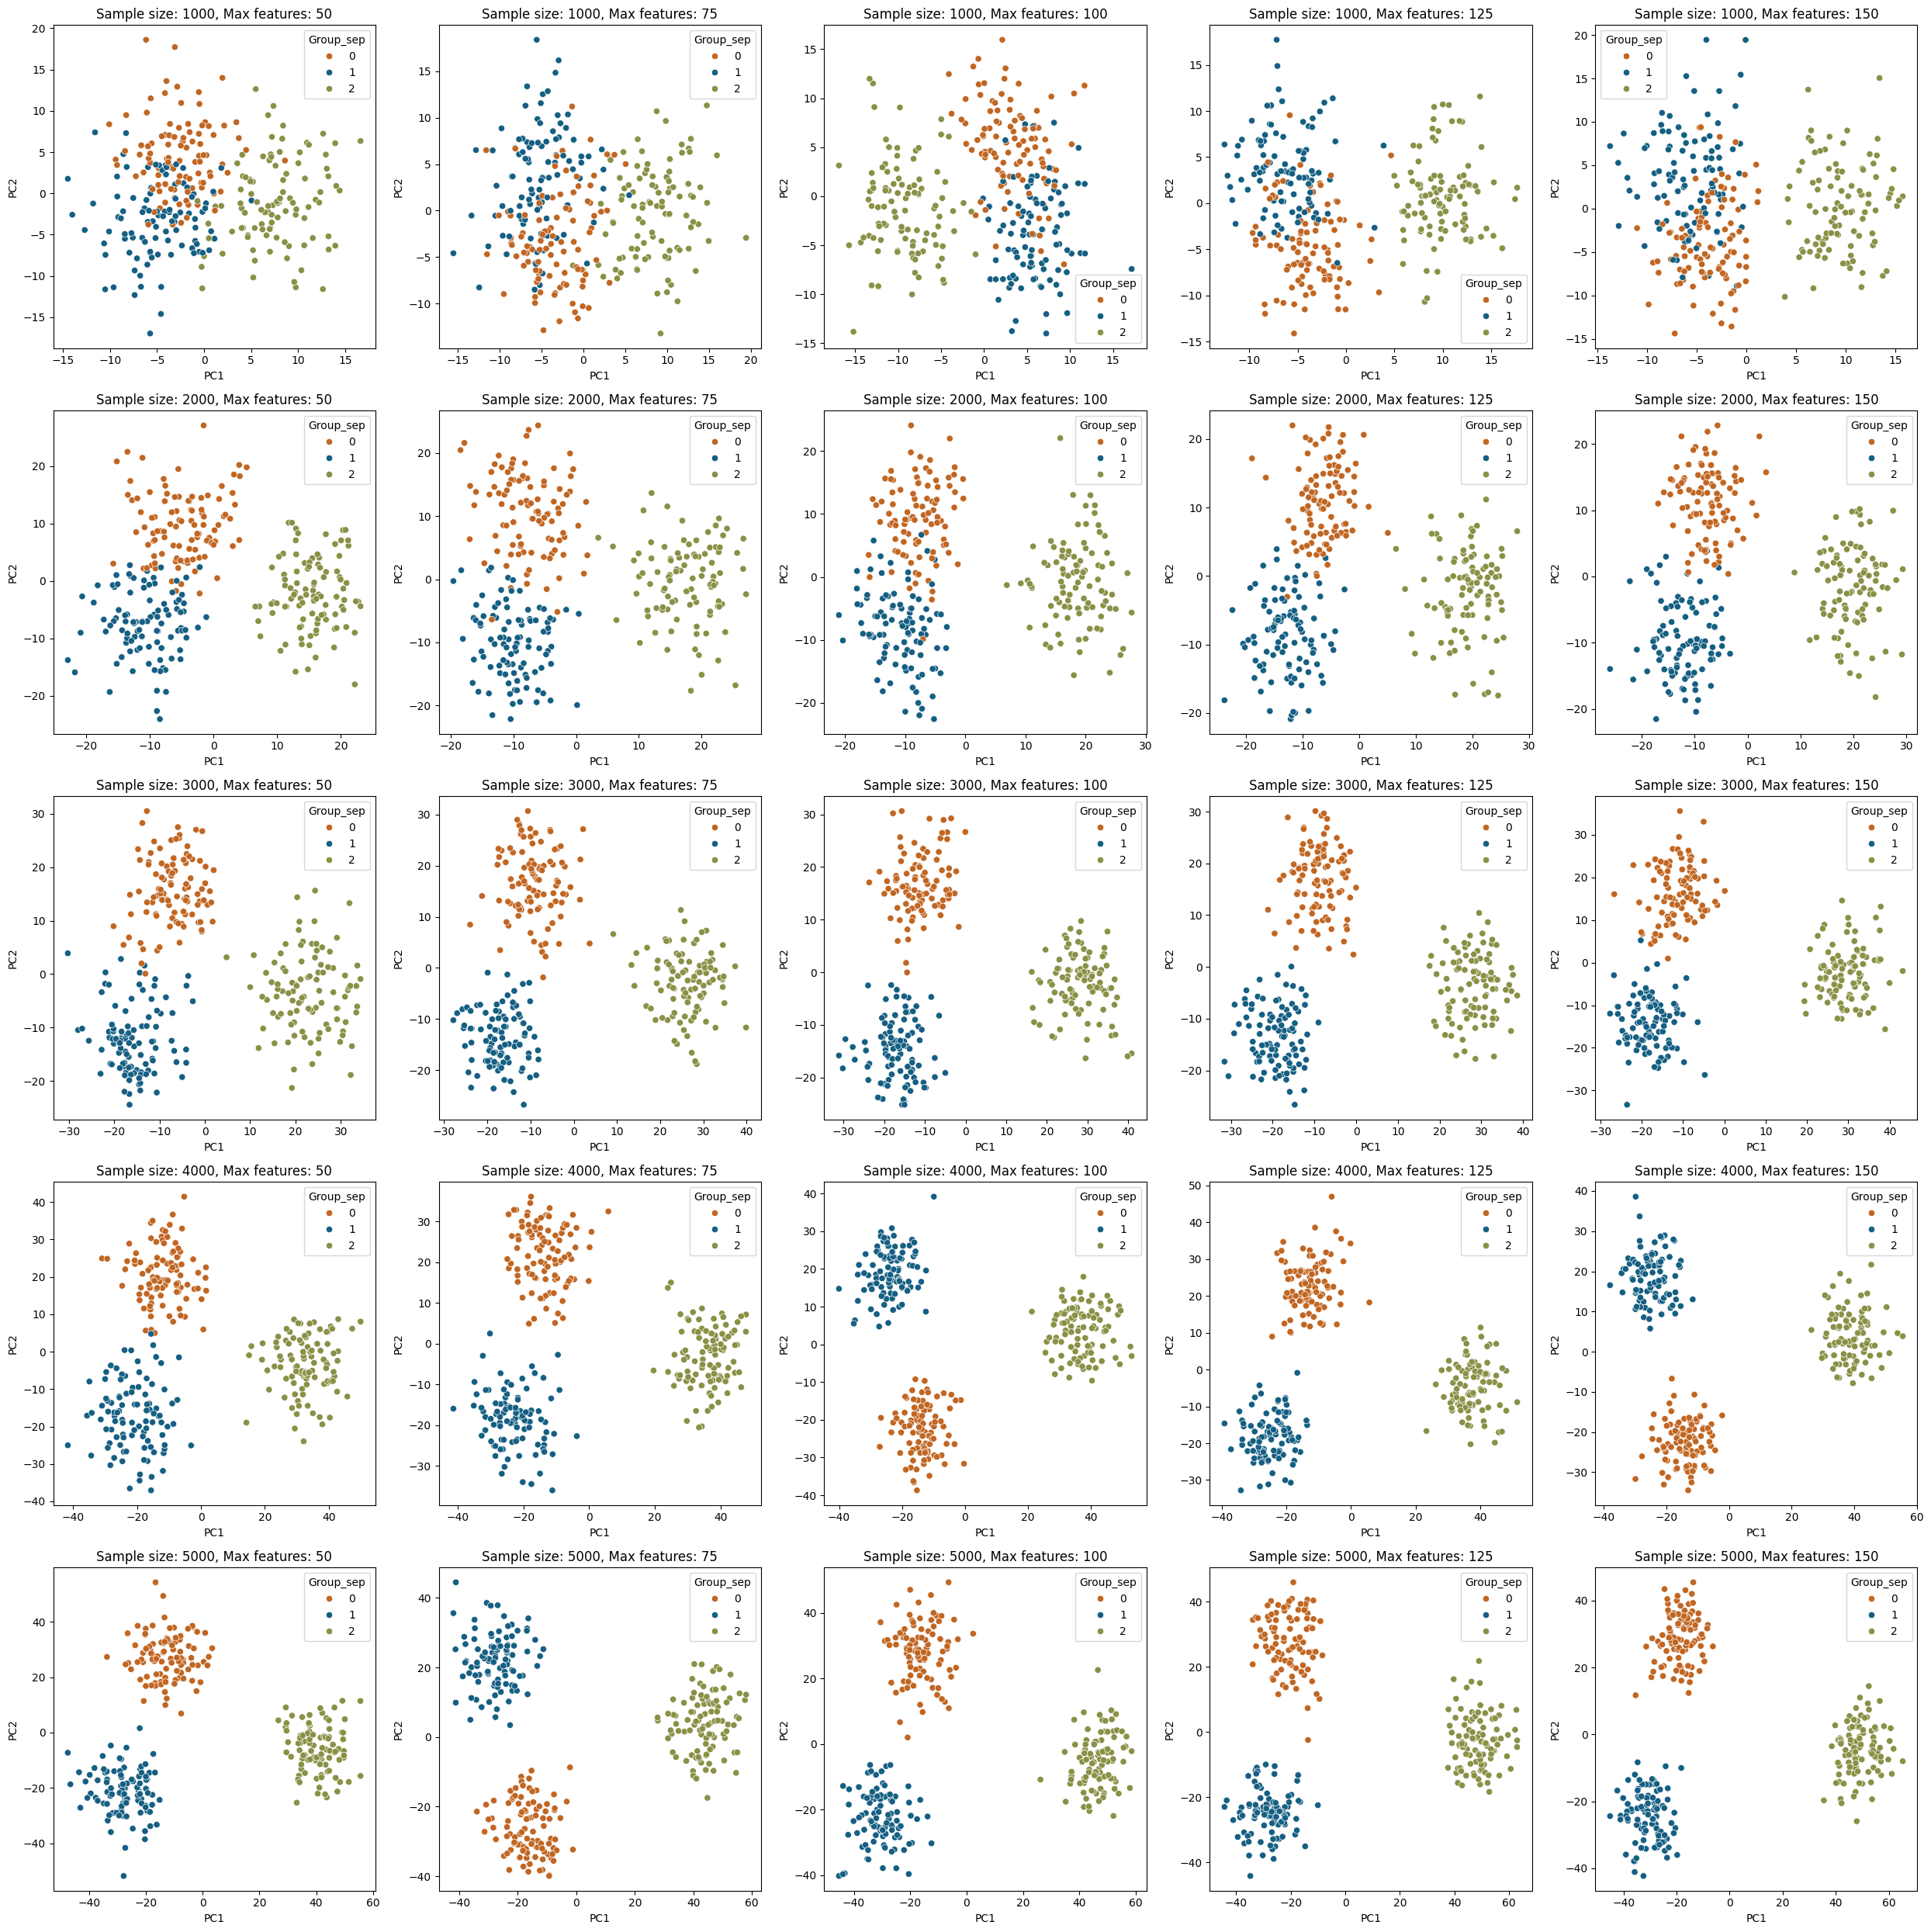

In [158]:
# 创建一个 5x5 的图像网格
fig, axs = plt.subplots(5, 5, figsize=(25, 25))

# 遍历所有的结果
for i, ((sample_size, max_features), cmex_temp_df_pca) in enumerate(cmex_pca_results.items()):
    # 计算当前子图的位置
    row = i // 5
    col = i % 5

    # 在当前子图中绘制散点图
    ax = axs[row, col]
    chicago_palette = {0: '#C16622FF', 1: '#155F83FF', 2: '#8A9045FF'}
    sns.scatterplot(data=cmex_temp_df_pca, x='PC1', y='PC2', hue='Group_sep', palette=chicago_palette, ax=ax)

    # 设置子图的标题
    ax.set_title(f'Sample size: {sample_size}, Max features: {max_features}')

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

### T-test on PCA results

In [ ]:
for i, ((sample_size, max_features), temp_df_pca_ttest) in enumerate(pca_results.items()):
    
    pca_result_ttest_df = temp_df_pca_ttest[['PC1', 'PC2', 'Group_sep']]

    # transform the dataframe to a long format
    pca_result_ttest_df = pca_result_ttest_df.melt(id_vars=['Group_sep'], value_vars=['PC1', 'PC2'])

    # retain Group_sep, meanwhile transform PC1 and PC2 to separate columns, turn the values to a list
    pca_result_ttest_df = pca_result_ttest_df.groupby(['Group_sep', 'variable'])['value'].apply(list).reset_index()
    
    # perform T-test to see if there is a significant difference between group 1-4, group 5-8 and group 9-12
    ttest_df = pca_result_ttest_df[['value', 'Group_sep', 'variable']]
    ttest_df = ttest_df.explode('value')

    # 将数据分成三组
    group_1_4_PC1 = ttest_df.query('variable == "PC1" and Group_sep == 0')['value']
    group_5_8_PC1 = ttest_df.query('variable == "PC1" and Group_sep == 1')['value']
    group_9_12_PC1 = ttest_df.query('variable == "PC1" and Group_sep == 2')['value']
    
    group_1_4_PC2 = ttest_df.query('variable == "PC2" and Group_sep == 0')['value']
    group_5_8_PC2 = ttest_df.query('variable == "PC2" and Group_sep == 1')['value']
    group_9_12_PC2 = ttest_df.query('variable == "PC2" and Group_sep == 2')['value']

    # 进行 T 检验
    t1_PC1, p1_PC1, df1_PC1 = ttest_ind(group_1_4_PC1, group_5_8_PC1)
    t2_PC1, p2_PC1, df2_PC1 = ttest_ind(group_1_4_PC1, group_9_12_PC1)
    t3_PC1, p3_PC1, df3_PC1 = ttest_ind(group_5_8_PC1, group_9_12_PC1)
    
    t1_PC2, p1_PC2, df1_PC2 = ttest_ind(group_1_4_PC2, group_5_8_PC2)
    t2_PC2, p2_PC2, df2_PC2 = ttest_ind(group_1_4_PC2, group_9_12_PC2)
    t3_PC2, p3_PC2, df3_PC2 = ttest_ind(group_5_8_PC2, group_9_12_PC2)
    
    print(f'Sample size: {sample_size}, Max features: {max_features}')
    print('T-test results for PC1:')
    print('T-test results for Group 1-4 and Group 5-8: t = %.3f, p = %.3f' % (t1_PC1, p1_PC1))
    print('T-test results for Group 1-4 and Group 9-12: t = %.3f, p = %.3f' % (t2_PC1, p2_PC1))
    print('T-test results for Group 5-8 and Group 9-12: t = %.3f, p = %.3f' % (t3_PC1, p3_PC1))
    print('T-test results for PC2:')
    print('T-test results for Group 1-4 and Group 5-8: t = %.3f, p = %.3f' % (t1_PC2, p1_PC2))
    print('T-test results for Group 1-4 and Group 9-12: t = %.3f, p = %.3f' % (t2_PC2, p2_PC2))
    print('T-test results for Group 5-8 and Group 9-12: t = %.3f, p = %.3f' % (t3_PC2, p3_PC2))
    print('')

### T-SNE: t-distributed Stochastic Neighbor Embedding [Chaunice's version]

In [143]:
# perform t-sne to see if there is a significant difference between group 1-4, group 5-8 and group 9-12
def cmex_tsne(dataframe, sample_size, max_features, n_components):
    # 创建 df 的副本
    df = dataframe.copy()
    
    # 重复100次，每次都从每个组中随机抽取 max_features 个字符，然后计算字符计数矩阵
    char_counts_list = []
    for i in range(100):
        df_sample = df.groupby('Group_sep').apply(lambda x: sample_chars(''.join(x['Prose']), sample_size), include_groups=False).reset_index()
        df_sample[0] = df_sample[0].apply(lambda x: ''.join(list(x)))
        vectorizer = CountVectorizer(analyzer='char', max_features=max_features)
        char_counts = vectorizer.fit_transform(df_sample[0])
        char_counts_df = pd.DataFrame(char_counts.toarray(), columns=vectorizer.get_feature_names_out())
        char_counts_list.append(char_counts_df)
        
    # 将所有字符计数矩阵连接起来，保留分组信息
    char_counts_df = pd.concat(char_counts_list, keys=range(100))

    # 将空值替换为 0
    char_counts_df = char_counts_df.fillna(0)

    # 转换 char_counts_df，将分组信息转换为列
    char_counts_df = char_counts_df.reset_index().rename(columns={'level_0': 'Sample', 'level_1': 'Group_sep'})

    # 分组进行t-sne，保留分组信息方便后续绘图
    tsne = TSNE(n_components=n_components)
    char_counts_df_tsne = tsne.fit_transform(char_counts_df.drop(['Sample', 'Group_sep'], axis=1))
    char_counts_df_tsne = pd.DataFrame(char_counts_df_tsne, columns=['tsne1', 'tsne2'])
    char_counts_df_tsne['Sample'] = char_counts_df['Sample']
    char_counts_df_tsne['Group_sep'] = char_counts_df['Group_sep']
    return char_counts_df_tsne

In [144]:
# 初始化一个空字典来保存结果
cmex_tsne_results = {}

# 遍历样本大小
for sample_size in [1000, 2000, 3000, 4000, 5000]:
    # 遍历特征数量
    for max_features in [50, 75, 100, 125, 150]:
        # 调用函数并保存结果
        key = (sample_size, max_features)
        cmex_tsne_results[key] = cmex_tsne(df, sample_size, max_features, 2)

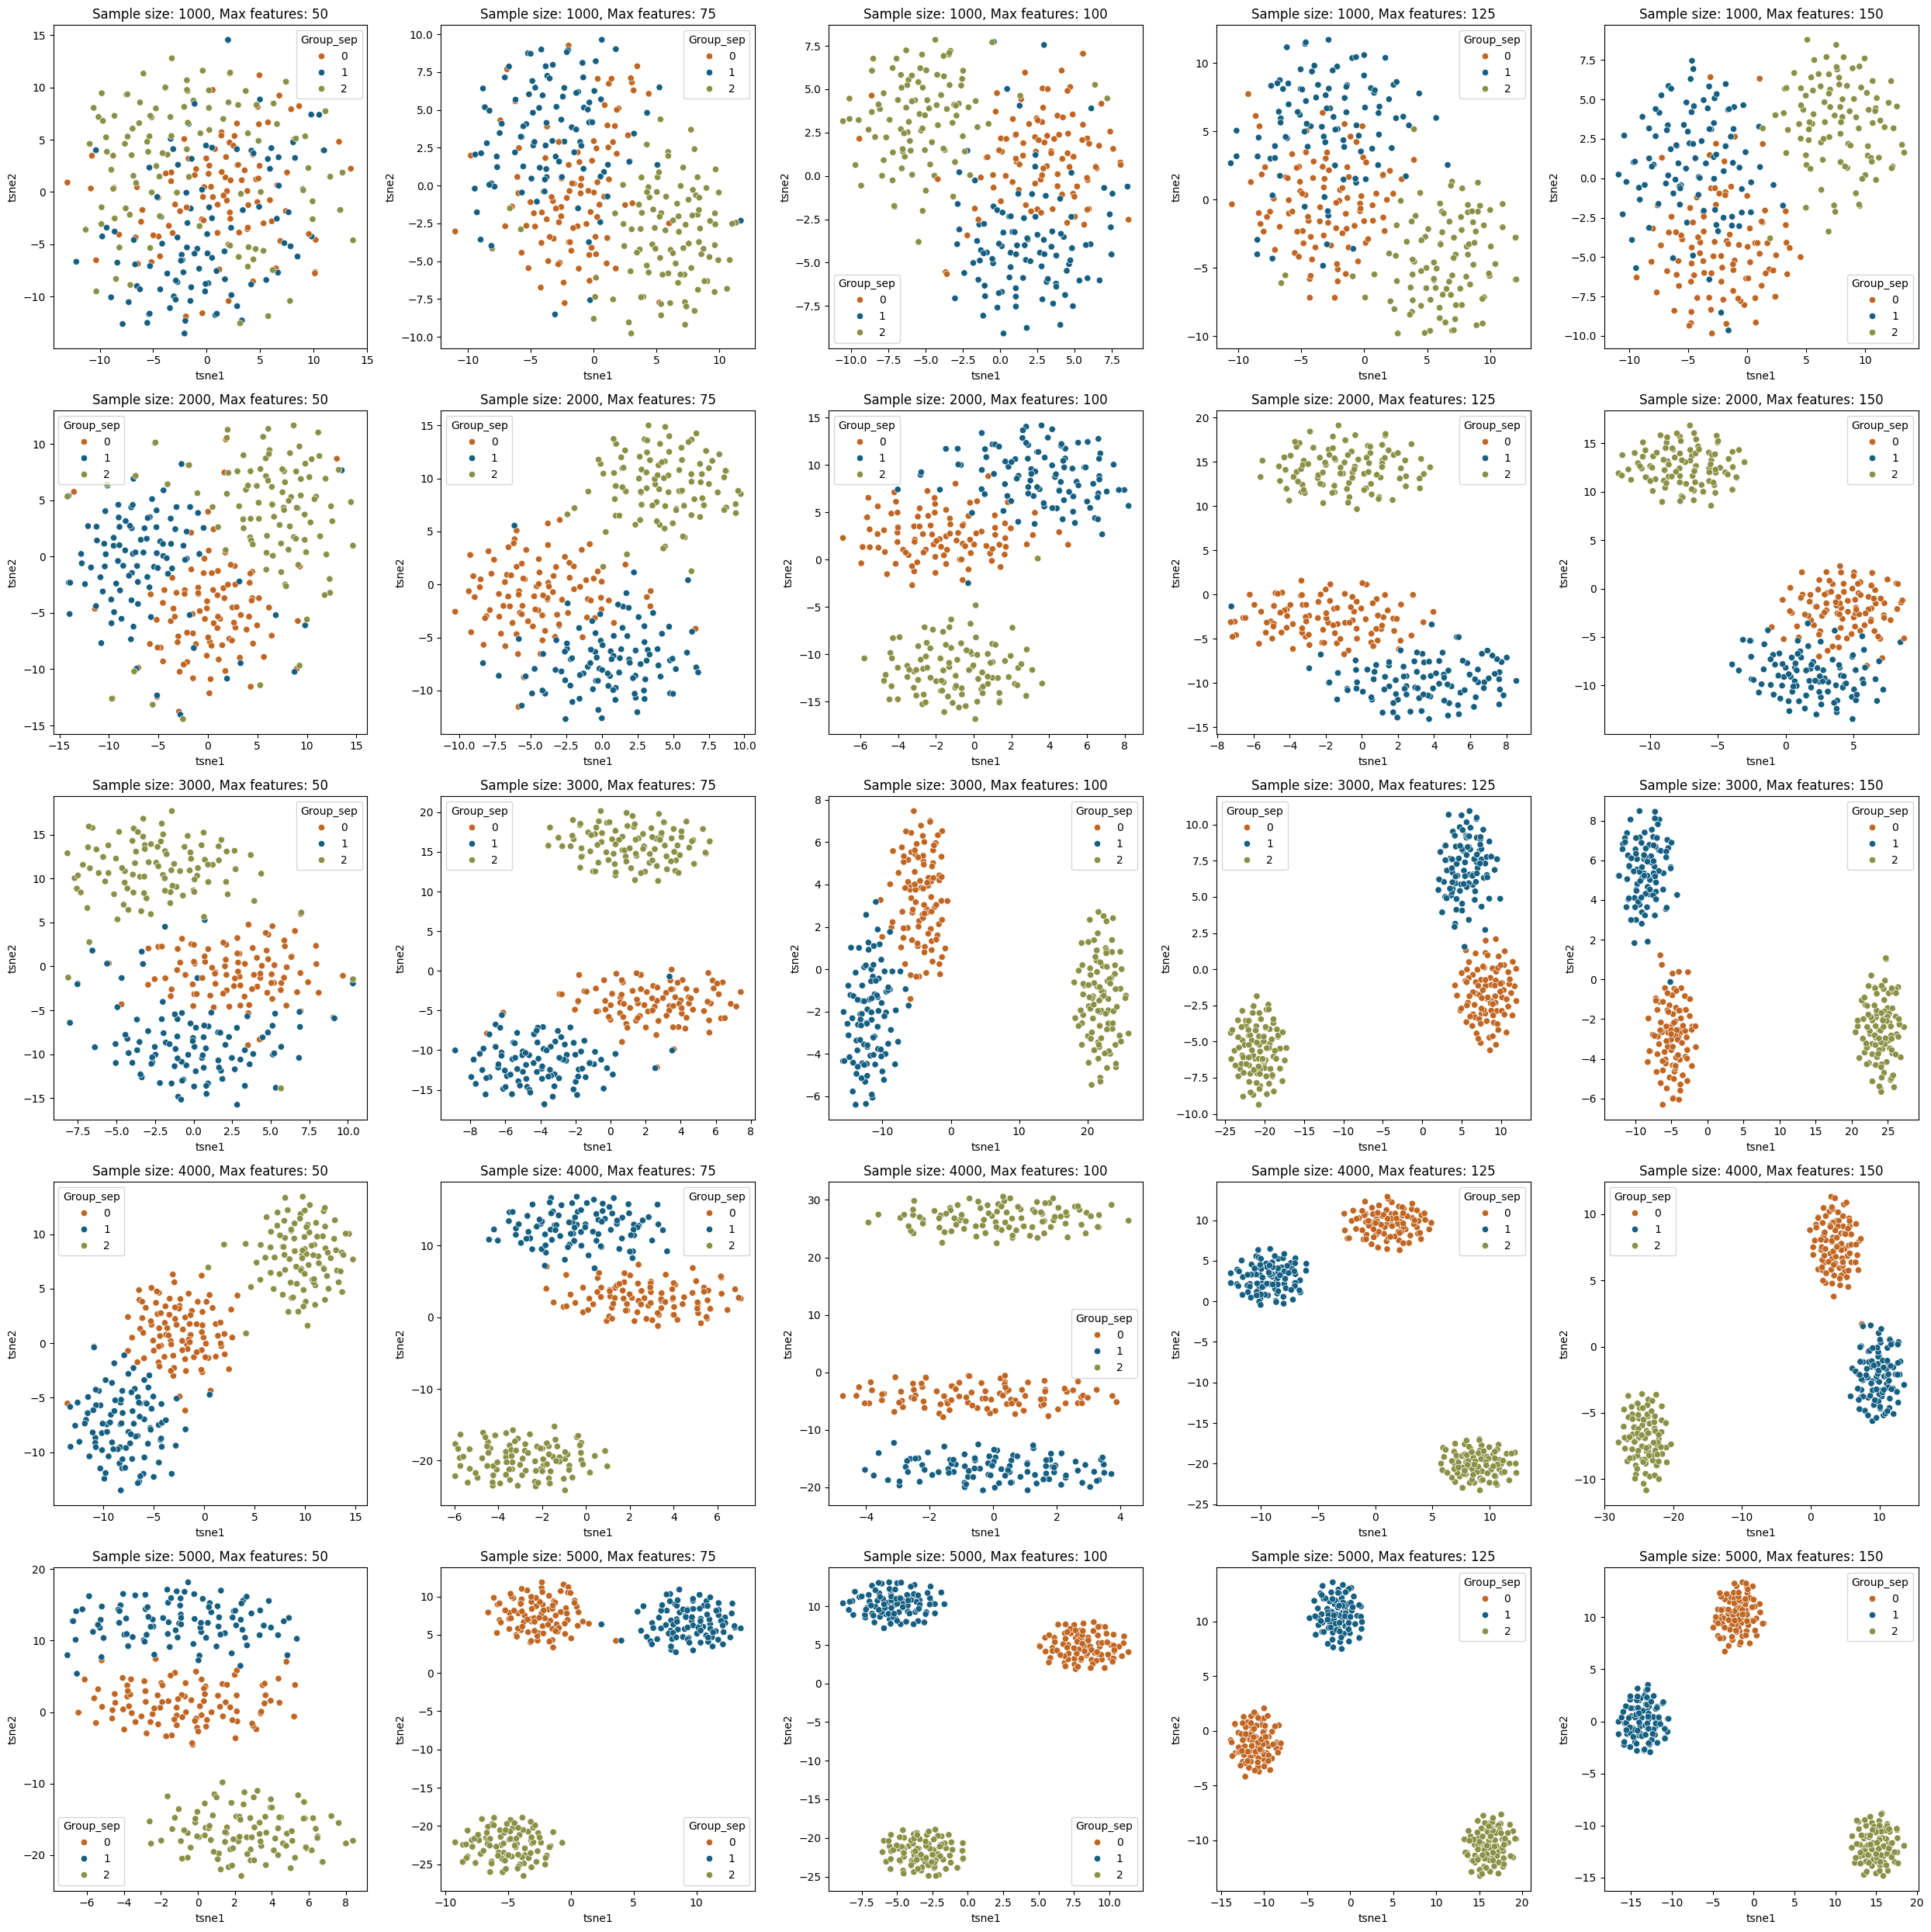

In [145]:
# 创建一个 5x5 的图像网格
fig, axs = plt.subplots(5, 5, figsize=(25, 25))

# 遍历所有的结果
for i, ((sample_size, max_features), cmex_temp_df_tsne) in enumerate(cmex_tsne_results.items()):
    # 计算当前子图的位置
    row = i // 5
    col = i % 5

    # 在当前子图中绘制散点图
    ax = axs[row, col]
    chicago_palette = {0: '#C16622FF', 1: '#155F83FF', 2: '#8A9045FF'}
    sns.scatterplot(data=cmex_temp_df_tsne, x='tsne1', y='tsne2', hue='Group_sep', palette=chicago_palette, ax=ax)

    # 设置子图的标题
    ax.set_title(f'Sample size: {sample_size}, Max features: {max_features}')

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

### T-test on T-SNE results

In [ ]:
for i, ((sample_size, max_features), temp_df_tsne_ttest) in enumerate(tsne_results.items()):
    
    tsne_result_ttest_df = temp_df_tsne_ttest[['tsne1', 'tsne2', 'Group_sep']]

    # transform the dataframe to a long format
    tsne_result_ttest_df = tsne_result_ttest_df.melt(id_vars=['Group_sep'], value_vars=['tsne1', 'tsne2'])

    # retain Group_sep, meanwhile transform PC1 and PC2 to separate columns, turn the values to a list
    tsne_result_ttest_df = tsne_result_ttest_df.groupby(['Group_sep', 'variable'])['value'].apply(list).reset_index()
    
    # perform T-test to see if there is a significant difference between group 1-4, group 5-8 and group 9-12
    ttest_df = tsne_result_ttest_df[['value', 'Group_sep', 'variable']]
    ttest_df = ttest_df.explode('value')

    # 将数据分成三组
    group_1_4_tsne1 = ttest_df.query('variable == "tsne1" and Group_sep == 0')['value']
    group_5_8_tsne1 = ttest_df.query('variable == "tsne1" and Group_sep == 1')['value']
    group_9_12_tsne1 = ttest_df.query('variable == "tsne1" and Group_sep == 2')['value']
    
    group_1_4_tsne2 = ttest_df.query('variable == "tsne2" and Group_sep == 0')['value']
    group_5_8_tsne2 = ttest_df.query('variable == "tsne2" and Group_sep == 1')['value']
    group_9_12_tsne2 = ttest_df.query('variable == "tsne2" and Group_sep == 2')['value']

    # 进行 T 检验
    t1_tsne1, p1_tsne1, df1_tsne1 = ttest_ind(group_1_4_tsne1, group_5_8_tsne1)
    t2_tsne1, p2_tsne1, df2_tsne1 = ttest_ind(group_1_4_tsne1, group_9_12_tsne1)
    t3_tsne1, p3_tsne1, df3_tsne1 = ttest_ind(group_5_8_tsne1, group_9_12_tsne1)
    
    t1_tsne2, p1_tsne2, df1_tsne2 = ttest_ind(group_1_4_tsne2, group_5_8_tsne2)
    t2_tsne2, p2_tsne2, df2_tsne2 = ttest_ind(group_1_4_tsne2, group_9_12_tsne2)
    t3_tsne2, p3_tsne2, df3_tsne2 = ttest_ind(group_5_8_tsne2, group_9_12_tsne2)
    
    print(f'Sample size: {sample_size}, Max features: {max_features}')
    print('T-test results for tsne1:')
    print('T-test results for Group 1-4 and Group 5-8: t = %.3f, p = %.3f' % (t1_tsne1, p1_tsne1))
    print('T-test results for Group 1-4 and Group 9-12: t = %.3f, p = %.3f' % (t2_tsne1, p2_tsne1))
    print('T-test results for Group 5-8 and Group 9-12: t = %.3f, p = %.3f' % (t3_tsne1, p3_tsne1))
    print('T-test results for tsne1:')
    print('T-test results for Group 1-4 and Group 5-8: t = %.3f, p = %.3f' % (t1_tsne2, p1_tsne2))
    print('T-test results for Group 1-4 and Group 9-12: t = %.3f, p = %.3f' % (t2_tsne2, p2_tsne2))
    print('T-test results for Group 5-8 and Group 9-12: t = %.3f, p = %.3f' % (t3_tsne2, p3_tsne2))
    print('')